In [1]:
from experiments_deblurring import *

/users/eleves-b/2021/jeremie.touati/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:datasets:PyTorch version 2.5.1 available.


## Loading dataset and denoisers

In [3]:
std_noise_train = 0.05
std_noise = 0.05
components_list = [10, 50]
layers_list = [1, 20]
n_rep_list = [1, 10, 50, 100, 1000]
denoiser_type_list = ["SD"]
pth_kernel = "blur_models/blur_3.mat"
img_list = [0]
n_iter_per_lambda = 200
n_lambda = 50
lambda_start = 10
lambda_end = 1e-5
eps_stop = 1e-6
warm_restart = True

params_model = {
        "kernel_size": 5,
        "lmbd": 1e-4,
        "color": COLOR,
        "device": DEVICE,
        "dtype": torch.float,
        "optimizer": "adam",
        "path_data": DATA_PATH,
        "max_sigma_noise": std_noise_train,
        "min_sigma_noise": std_noise_train,
        "mini_batch_size": 1,
        "max_batch": 10,
        "epochs": 50,
        "avg": False,
        "rescale": False,
        "fixed_noise": True,
        "D_shared": True,
        "step_size_scaling": 1.8,
        "lr": 1e-3,
        "dataset": DATASET,
    }

In [4]:
T_START = time.time()

DENOISERS = {"DRUNet": dict(model="drunet")}
DENOISERS["DRUNet"]["net"] = get_denoiser(**DENOISERS["DRUNet"])

for denoiser_type in denoiser_type_list:
    for components in components_list:
        for layers in layers_list:
            params = {k: v for k, v in params_model.items()}
            params["n_layers"] = layers
            params["n_components"] = components
            
            # ----- #REPEAT = #LAYERS -----
            if denoiser_type == "SD":
                base_name = f"SD_{components}C_{layers}L"
                model_type = "synthesis"
            elif denoiser_type == "AD":
                base_name = f"AD_{components}C_{layers}L"
                model_type = "analysis"
            
            name = f"{base_name}_{layers}R"
            DENOISERS[name] = {"model": model_type, **params}
            print(f"Training {base_name}...")
            DENOISERS[name]["net"] = get_denoiser(**DENOISERS[name])
            
            # ----- #REPEAT = 1 -----
            if layers > 1:
                denoiser = DENOISERS[name]
                old_net = denoiser["net"]
                net = UnrolledCDL(
                    type_unrolling=denoiser["model"],
                    **{k: v for k, v in denoiser.items() if k not in ["model", "net"]}
                ).unrolled_net
                # Replace the model with only the first layer of the trained model
                net.parameter = old_net.parameter
                net.model = torch.nn.ModuleList([old_net.model[0]])
                DENOISERS[f"{base_name}_1R"] = dict(net=net, model=denoiser["model"], **params)
                DENOISERS[f"{base_name}_1R"]["n_layers"] = 1
            
            # ----- #REPEAT = N_REP -----
            for n_rep in n_rep_list:
                if n_rep == layers:
                    continue
                denoiser = DENOISERS[f"{base_name}_1R"]
                old_net = denoiser["net"]
                net = UnrolledCDL(
                    type_unrolling=denoiser["model"],
                    **{k: v for k, v in denoiser.items() if k not in ["model", "net"]}
                ).unrolled_net
                assert len(net.model) == 1
                net.parameter = old_net.parameter
                net.model = torch.nn.ModuleList([old_net.model[0]] * n_rep)
                DENOISERS[f"{base_name}_{n_rep}R"] = dict(
                    net=net, model=denoiser["model"], **params
                )
                DENOISERS[f"{base_name}_{n_rep}R"]["n_layers"] = n_rep

print(f"\nSuccessfully prepared {len(DENOISERS.keys())} denoisers in {time.time() - T_START:.2f} seconds.")

Training SD_10C_1L...


Epoch 50 - Average train loss: 0.06480838 - Average test loss: 0.06009800: 100%|██████████| 50/50 [00:03<00:00, 13.36it/s]


Done
Training SD_10C_20L...


Epoch 50 - Average train loss: 0.00269176 - Average test loss: 0.00261558: 100%|██████████| 50/50 [00:08<00:00,  5.85it/s]


Done
Training SD_50C_1L...


Epoch 50 - Average train loss: 0.06321905 - Average test loss: 0.05791021: 100%|██████████| 50/50 [00:03<00:00, 16.01it/s]


Done
Training SD_50C_20L...


Epoch 50 - Average train loss: 0.00167074 - Average test loss: 0.00162557: 100%|██████████| 50/50 [00:15<00:00,  3.26it/s]

Done

Successfully prepared 23 denoisers in 33.78 seconds.


In [5]:
dataloader = create_dataloader(
    DATA_PATH,
    min_sigma_noise=std_noise,
    max_sigma_noise=std_noise,
    device=DEVICE,
    dtype=torch.float,
    mini_batch_size=1,
    train=False,
    color=COLOR,
    fixed_noise=True,
    crop=False,
)

In [6]:
img = dataloader.dataset[img_list[0]][1].cpu().numpy()
x_truth = img

In [7]:
h = scipy.io.loadmat(pth_kernel)
h = np.array(h["blur"])

Phi, Phit = get_operators(type_op="deconvolution", pth_kernel=pth_kernel)
x_blurred = Phi_channels(img, Phi)
nc, nxb, nyb = x_blurred.shape
x_observed = x_blurred + std_noise * np.random.randn(nc, nxb, nyb)
normPhi2 = op_norm2(Phi, Phit, x_observed.shape)
gamma = 1.0 / normPhi2

In [8]:
results = {
    "observation": x_observed,
    "truth": img
}

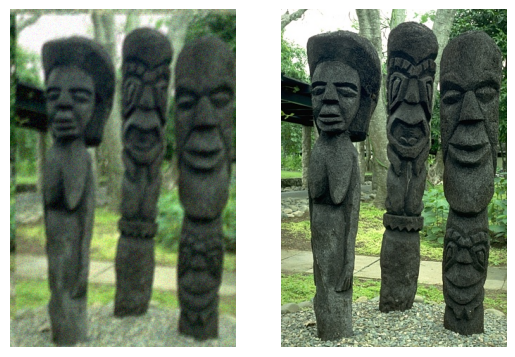

PSNR: 14.38 dB


/tmp/ipykernel_256849/2873729282.py:14: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  print(f"PSNR: {peak_signal_noise_ratio(x_truth, x_observed.clip(0, 1)):.2f} dB")


In [9]:
def show_imgs(list_img, figsize=None, two_d=False):
    plt.figure(figsize=figsize)
    for i, img in enumerate(list_img):
        plt.subplot(1, len(list_img), i + 1)
        if two_d:
            img = img.squeeze()
        else:
            img = img.transpose(1, 2, 0)
        plt.imshow(img)
        plt.axis("off")
    plt.show()

show_imgs([x_observed.clip(0,1), x_truth])
print(f"PSNR: {peak_signal_noise_ratio(x_truth, x_observed.clip(0, 1)):.2f} dB")

## Baseline with PnP-DRUNet

In [ ]:
eps_stop = None
denoiser_name = "DRUNet"

denoiser = DENOISERS[denoiser_name]
net = denoiser["net"]
model = "drunet"
model_type = denoiser["model"]

In [ ]:
n_lambda = 50
lambda_list = np.logspace(np.log10(1e3), np.log10(1e-3), n_lambda)
n_iter_per_lambda = 500

n_lambda = len(lambda_list)
if lambda_list is None:
    lambda_list = [0.5 * std_noise] * n_lambda

x_n = Phi_channels(x_observed, Phit)
best_x_psnr = x_n.copy()
best_x_error = x_n.copy()
best_psnr = 0
best_error = 0
best_lambda = 0

cvg = [1e10] * n_lambda*n_iter_per_lambda
psnr = [0] * n_lambda
error = [0] * n_lambda
psnr_inner = [0] * n_lambda*n_iter_per_lambda
error_inner = [0] * n_lambda*n_iter_per_lambda
runtime = [0] * n_lambda*n_iter_per_lambda
stops = [0] * (n_lambda+1)

current_dual = None
current_dual_fast = None

best_current_dual, best_current_dual_fast = None, None

t_iter = 0

i = 0
for k in tqdm(range(n_lambda)):
    if not warm_restart:
        x_n = Phi_channels(x_observed, Phit)
        current_dual = None
        current_dual_fast = None
    
    for t in range(n_iter_per_lambda):
        t_start = time.perf_counter()
        g_n = Phi_channels((Phi_channels(x_n, Phi) - x_observed), Phit)
        tmp = x_n - gamma * g_n
        x_old = x_n.copy()

        x_n, current_dual = apply_model(
            model, tmp, current_dual, lambda_list[k], net, True
        )
        
        t_iter += time.perf_counter() - t_start
        cvg[i] = np.sum((x_n - x_old) ** 2)
        runtime[i] = t_iter
        psnr_inner[i] = peak_signal_noise_ratio(x_n, x_truth)
        criterion = np.sum((x_n - x_old) ** 2 / np.sum(x_old ** 2))
            
        if eps_stop is not None and criterion < eps_stop:
            break
        i += 1
    
    stops[k+1] = i
    
    if x_truth is not None:
        psnr[k] = psnr_inner[i-1]
        error[k] = error_inner[i-1]
        if psnr[k] > best_psnr:
            best_psnr = psnr[k]
            best_x_psnr = x_n.copy()
            best_lambda = lambda_list[k]
            bestb_current_dual = current_dual.copy() if current_dual is not None else None
            best_current_dual_fast = current_dual_fast.copy() if current_dual_fast is not None else None
        if error[k] < best_error:
            best_error = error[k]
            best_x_error = x_n.copy()
    
    plt.figure(figsize=(3, 1))
    plt.plot(psnr_inner[stops[k]:stops[k+1]])
    plt.show()

plt.figure(figsize=(8, 3))
plt.semilogx(lambda_list, psnr)
plt.xlabel(r"$\lambda$")
plt.ylabel("PSNR (dB)")
plt.suptitle(f"{denoiser_name}")
plt.tight_layout()
plt.show()

In [ ]:
import os
if not os.path.exists("convergence/DRUNet"):
    os.makedirs("convergence/DRUNet")

with open(f"convergence/DRUNet/results_optimal_lambda.pkl", "wb") as f:
    pickle.dump({
        "lambda_list": lambda_list,
        "psnr": psnr,
        "error": error,
        "psnr_inner": psnr_inner,
        "error_inner": error_inner,
        "runtime": runtime,
        "stops": stops,
        "best_x_psnr": best_x_psnr,
        "best_x_error": best_x_error,
        "best_lambda": best_lambda,
        "best_current_dual": best_current_dual,
        "best_current_dual_fast": best_current_dual_fast
    }, f)

/tmp/ipykernel_256849/3674235955.py:22: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  isnr = peak_signal_noise_ratio(x_truth, x_observed)


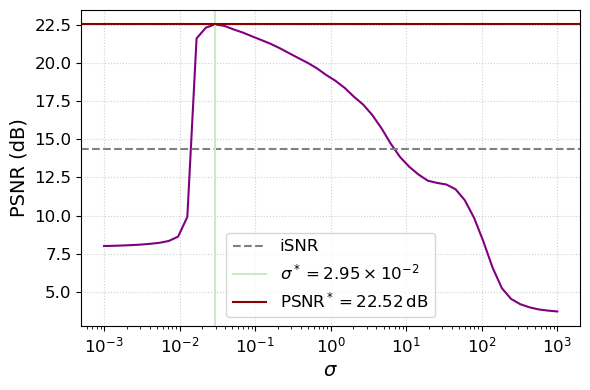

In [ ]:
# Load .pkl file
with open(f"convergence_deblurring/DRUNet/results_optimal_lambda.pkl", "rb") as f:
    results = pickle.load(f)
lambda_list = results["lambda_list"]
psnr = results["psnr"]
error = results["error"]
psnr_inner = results["psnr_inner"]
error_inner = results["error_inner"]
runtime = results["runtime"]
stops = results["stops"]
best_x_psnr = results["best_x_psnr"]
best_x_error = results["best_x_error"]
best_lambda = results["best_lambda"]
best_current_dual = results["best_current_dual"]
best_current_dual_fast = results["best_current_dual_fast"]


significand = best_lambda / (10 ** np.floor(np.log10(best_lambda)))
exponent = int(np.floor(np.log10(best_lambda)))

colors = plt.get_cmap("Pastel1").colors
isnr = peak_signal_noise_ratio(x_truth, x_observed)

plt.figure(figsize=(6, 4))
plt.semilogx(lambda_list, psnr, color="purple")
plt.axhline(isnr, color='grey', linestyle='--', label='iSNR')
plt.axvline(
    best_lambda, color=colors[2], linewidth=1.5,
    label=rf"$\sigma^* = {significand:.2f} \times 10^{{{exponent}}}$"
)
plt.axhline(
    22.52, color="darkred", linewidth=1.5,
    label=rf"$\mathrm{{PSNR}}^* = {22.52:.2f}\,\mathrm{{dB}}$"
)

plt.xlabel(r"$\sigma$", fontsize=14)
plt.ylabel("PSNR (dB)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.savefig("convergence_deblurring/DRUNet/psnr_vs_lambda.pdf", bbox_inches='tight')

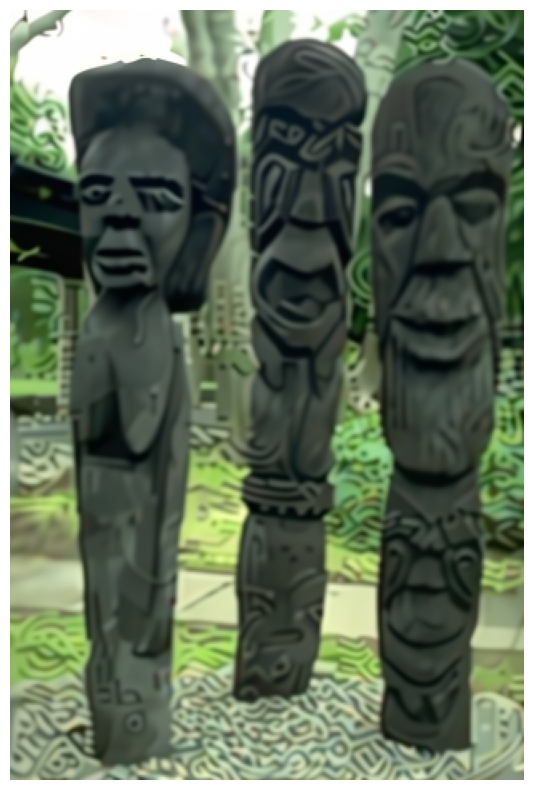

In [ ]:
# Show and save x_n
plt.figure(figsize=(10,10))
plt.imshow(best_x_psnr.transpose(1, 2, 0))
plt.axis('off')
plt.savefig(f"images_deblurring/drunet.png", bbox_inches='tight')
plt.show()

## Debiaising and comparing $l_1$ with $l_2$

In [17]:
denoiser_names = ["SD_50C_1L_50R"]

In [ ]:
for denoiser_name in denoiser_names:
    
    print(f"\nRunning denoiser: {denoiser_name}")

    denoiser = DENOISERS[denoiser_name]
    net = denoiser["net"]
    model = "unrolled"
    
    lambdas = [6.62e-2]
    n = len(lambdas)
    plt.figure(figsize=(16, 3*n))
    i = 0
    
    for best_lambda in lambdas:
        
        x_n = Phi_channels(x_observed, Phit)
        current_dual = None
        current_dual_fast = None

        iter_final = 100
        error_final = [0] * iter_final
        psnr_final = [0] * iter_final
        best_psnr = 0
        runtime_final = [0] * iter_final
        cvg_final = [0] * iter_final
        t_iter = 0
        update_dual = True

        for t in tqdm(range(iter_final)):
            
            t_start = time.perf_counter()

            g_n = Phi_channels((Phi_channels(x_n, Phi) - x_observed), Phit)
            tmp = x_n - gamma * g_n
            
            
            x_old = x_n.copy()
            alpha = t/(t+4)
            #alpha = 0
            x_n, current_dual, current_dual_fast = apply_model(
                model, tmp, current_dual, best_lambda, net, update_dual,
                fast=True, dual_fast=current_dual_fast, alpha_fast=alpha
            )

            t_iter += time.perf_counter() - t_start
            runtime_final[t] = t_iter
            cvg_final[t] = np.sum((x_n - x_old) ** 2)
            psnr_final[t] = peak_signal_noise_ratio(x_n, x_truth)
            error_final[t] = error_synthesis(current_dual[0], x_observed, net, Phi, best_lambda)
            
            if psnr_final[t] > best_psnr:
                best_x = x_n.copy()
                best_dual = current_dual.copy()
                best_psnr = psnr_final[t]
                
                
        plt.subplot(n, 4, 4*i+1)
        
        plt.text(-0.3, 0.5, f"λ = {best_lambda:.0e}", fontsize=16,
                 transform=plt.gca().transAxes, rotation=90,
                 verticalalignment='center', horizontalalignment='right')
        
        plt.semilogx(np.arange(1, iter_final + 1), psnr_final, label="FISTA")
        plt.xlabel("Iterations")
        plt.ylabel("PSNR (dB)")
        plt.legend()

        plt.subplot(n, 4, 4*i+2)
        plt.semilogx(runtime_final, psnr_final, label="FISTA")
        plt.xlabel("Runtime (s)")
        plt.ylabel("PSNR (dB)")
        plt.legend()

        plt.subplot(n, 4, 4*i+3)
        plt.loglog(np.arange(1, iter_final + 1), error_final, label="FISTA")
        plt.xlabel("Iterations")
        plt.ylabel("Error")
        plt.legend()

        plt.subplot(n, 4, 4*i+4)
        plt.loglog(runtime_final, error_final, label="FISTA")
        plt.xlabel("Runtime (s)")
        plt.ylabel("Error")
        plt.legend()
        
        i += 1

    plt.suptitle(f"{denoiser_name}", fontsize=20)
    plt.tight_layout()
    plt.show()

In [19]:
support_z = current_dual != 0
support_z = torch.tensor(support_z, dtype=torch.float, device=DEVICE)
print(f"Proportion of zero elements in the dual: {np.mean(current_dual[0] == 0):.2%}")

parameter = net.parameter
iter_grad = 500
step_size = gamma*1/net.compute_lipschitz()
step_size_x = gamma

lamb = 1e-3
lamb_x = 1e-1

# GRADIENT DESCENT ON x
# x_n_fast = x_n.copy()
x_n_fast = np.zeros_like(x_n)
w_n = x_n_fast.copy()
psnr_unbiased_fast_x = []
error_unbiased_fast_x = []
for i in tqdm(range(iter_grad)):
    old_x_n = x_n_fast.copy()
    grad = Phi_channels(w_n, Phi) - x_observed
    error_unbiased_fast_x.append(np.linalg.norm(grad))
    grad = Phi_channels(grad, Phit)
    w_n -= step_size_x * grad
    x_n_fast = w_n * (1/(1+lamb_x))
    alpha_i = i / (i + 4)
    w_n = x_n_fast + alpha_i * (x_n_fast - old_x_n)
    psnr_unbiased_fast_x.append(peak_signal_noise_ratio(x_truth, x_n_fast))

# GRADIENT DESCENT ON z
#z_n_fast = current_dual.copy()
z_n_fast = np.zeros_like(current_dual)
z_n_fast = torch.tensor(z_n_fast, device=DEVICE, dtype=torch.float)
w_n = z_n_fast.clone()
psnr_unbiased_fast = []
error_unbiased_fast = []
for i in tqdm(range(iter_grad)):
    old_z_n = z_n_fast.clone()
    grad = net.convt(w_n, net.parameter).detach().cpu().numpy()
    grad = Phi_channels(grad, Phi) - x_observed
    error_unbiased_fast.append(np.linalg.norm(grad))
    grad = Phi_channels(grad, Phit)
    grad = torch.tensor(grad, device=DEVICE, dtype=torch.float)
    grad = net.conv(grad, net.parameter)
    w_n -= step_size * grad
    z_n_fast = w_n * (1/(1+lamb))
    x_unbiased_fast = net.convt(z_n_fast, net.parameter).detach().cpu().numpy()[0]
    alpha_i = i / (i + 4)
    w_n = z_n_fast + alpha_i * (z_n_fast - old_z_n)
    psnr_unbiased_fast.append(peak_signal_noise_ratio(x_truth, x_unbiased_fast))

# PROJECTED GRADIENT DESCENT ON z
#z_n_proj_fast = current_dual.copy()
z_n_proj_fast = np.zeros_like(current_dual)
z_n_proj_fast = torch.tensor(z_n_proj_fast, device=DEVICE, dtype=torch.float)
w_n = z_n_proj_fast.clone()
psnr_unbiased_proj_fast = []
error_unbiased_proj_fast = []
for i in tqdm(range(iter_grad)):
    old_z_n = z_n_proj_fast.clone()
    grad = net.convt(w_n, net.parameter).detach().cpu().numpy()
    grad = Phi_channels(grad, Phi) - x_observed
    error_unbiased_proj_fast.append(np.linalg.norm(grad))
    grad = Phi_channels(grad, Phit)
    grad = torch.tensor(grad, device=DEVICE, dtype=torch.float)
    grad = net.conv(grad, net.parameter)
    w_n -= step_size * grad
    z_n_proj_fast = w_n * support_z * (1/(1+lamb))
    x_unbiased_proj_fast = net.convt(z_n_proj_fast, net.parameter).detach().cpu().numpy()[0]
    alpha_i = i / (i + 4)
    w_n = z_n_proj_fast + alpha_i * (z_n_proj_fast - old_z_n)
    psnr_unbiased_proj_fast.append(peak_signal_noise_ratio(x_truth, x_unbiased_proj_fast))

Proportion of zero elements in the dual: 97.00%


100%|██████████| 500/500 [00:24<00:00, 20.32it/s]


In [20]:
# Save the results
results = {
    "psnr_unbiased_fast_x": psnr_unbiased_fast_x,
    "psnr_unbiased_fast": psnr_unbiased_fast,
    "psnr_unbiased_proj_fast": psnr_unbiased_proj_fast,
    "x_n_fast": x_n_fast,
    "x_unbiased_fast": x_unbiased_fast,
    "x_unbiased_proj_fast": x_unbiased_proj_fast,
}
with open("images_deblurring/unbiasing_SD_5K_50C_1L.pkl", "wb") as f:
    pickle.dump(results, f)

### SD_5K_10C_1L

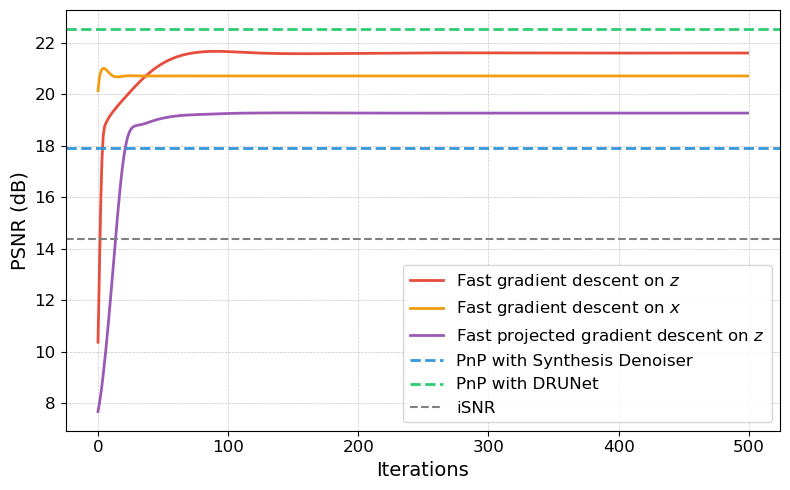

In [ ]:
# Load results from the saved file
with open("images_deblurring/unbiasing_SD_5K_10C_1L.pkl", "rb") as f:
    results = pickle.load(f)
psnr_unbiased_fast_x = results["psnr_unbiased_fast_x"]
psnr_unbiased_fast = results["psnr_unbiased_fast"]
psnr_unbiased_proj_fast = results["psnr_unbiased_proj_fast"]

plt.figure(figsize=(8, 5))

colors = {
    "drunet": "#2ecc71",
    "synthesis": "#3498db",
    "proj_z": "#9b59b6",
    "gd_x": "#f39c12",
    "gd_z": "#e74c3c",
}

plt.plot(psnr_unbiased_fast, label=rf"Fast gradient descent on $z$", color=colors["gd_z"], linewidth=2)
plt.plot(psnr_unbiased_fast_x, label=rf"Fast gradient descent on $x$", color=colors["gd_x"], linewidth=2)
plt.plot(psnr_unbiased_proj_fast, label=rf"Fast projected gradient descent on $z$", color=colors["proj_z"], linewidth=2)

plt.axhline(17.9, linestyle='--', label="PnP with Synthesis Denoiser", color=colors["synthesis"], linewidth=2)
plt.axhline(22.52, linestyle='--', label="PnP with DRUNet", color=colors["drunet"], linewidth=2)
plt.axhline(14.38, linestyle='--', label="iSNR", color="grey")

plt.xlabel("Iterations", fontsize=14)
plt.ylabel("PSNR (dB)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig("images_deblurring/unbiasing_SD_5K_10C_1L.pdf", bbox_inches="tight")
plt.show()

### SD_5K_50C_1L

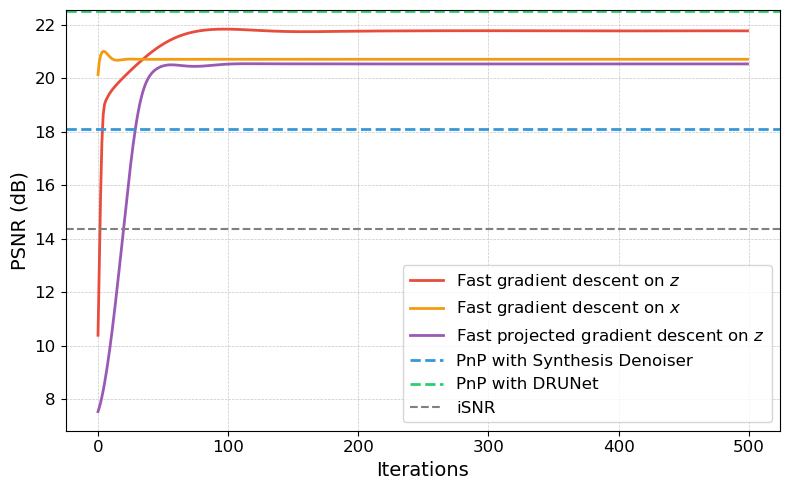

In [ ]:
# Load results from the saved file
with open("images_deblurring/unbiasing_SD_5K_50C_1L.pkl", "rb") as f:
    results = pickle.load(f)
psnr_unbiased_fast_x = results["psnr_unbiased_fast_x"]
psnr_unbiased_fast = results["psnr_unbiased_fast"]
psnr_unbiased_proj_fast = results["psnr_unbiased_proj_fast"]

plt.figure(figsize=(8, 5))

plt.plot(psnr_unbiased_fast, label=rf"Fast gradient descent on $z$", color=colors["gd_z"], linewidth=2)
plt.plot(psnr_unbiased_fast_x, label=rf"Fast gradient descent on $x$", color=colors["gd_x"], linewidth=2)
plt.plot(psnr_unbiased_proj_fast, label=rf"Fast projected gradient descent on $z$", color=colors["proj_z"], linewidth=2)

plt.axhline(18.09, linestyle='--', label="PnP with Synthesis Denoiser", color=colors["synthesis"], linewidth=2)
plt.axhline(22.52, linestyle='--', label="PnP with DRUNet", color=colors["drunet"], linewidth=2)
plt.axhline(14.38, linestyle='--', label="iSNR", color="grey")

plt.xlabel("Iterations", fontsize=14)
plt.ylabel("PSNR (dB)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig("images_deblurring/unbiasing_SD_5K_50C_1L.pdf", bbox_inches="tight")
plt.show()

### SD_16K_10C_1L

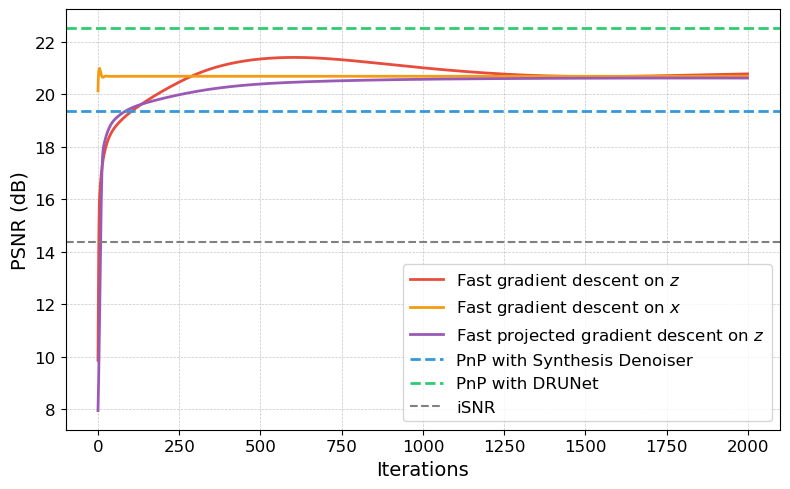

In [ ]:
# Load results from the saved file
with open("images_deblurring/unbiasing_SD_16K_10C_1L.pkl", "rb") as f:
    results = pickle.load(f)
psnr_unbiased_fast_x = results["psnr_unbiased_fast_x"]
psnr_unbiased_fast = results["psnr_unbiased_fast"]
psnr_unbiased_proj_fast = results["psnr_unbiased_proj_fast"]

plt.figure(figsize=(8, 5))

plt.plot(psnr_unbiased_fast, label=rf"Fast gradient descent on $z$", color=colors["gd_z"], linewidth=2)
plt.plot(psnr_unbiased_fast_x, label=rf"Fast gradient descent on $x$", color=colors["gd_x"], linewidth=2)
plt.plot(psnr_unbiased_proj_fast, label=rf"Fast projected gradient descent on $z$", color=colors["proj_z"], linewidth=2)

plt.axhline(19.37, linestyle='--', label="PnP with Synthesis Denoiser", color=colors["synthesis"], linewidth=2)
plt.axhline(22.52, linestyle='--', label="PnP with DRUNet", color=colors["drunet"], linewidth=2)
plt.axhline(14.38, linestyle='--', label="iSNR", color="grey")

plt.xlabel("Iterations", fontsize=14)
plt.ylabel("PSNR (dB)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig("images_deblurring/unbiasing_SD_16K_10C_1L.pdf", bbox_inches="tight")
plt.show()

### SD_16K_50C_1L

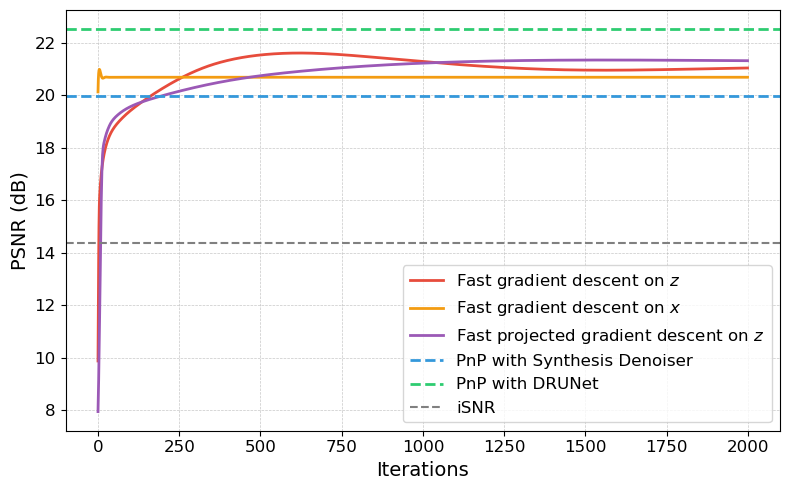

In [ ]:
# Load results from the saved file
with open("images_deblurring/unbiasing_SD_16K_50C_1L.pkl", "rb") as f:
    results = pickle.load(f)
psnr_unbiased_fast_x = results["psnr_unbiased_fast_x"]
psnr_unbiased_fast = results["psnr_unbiased_fast"]
psnr_unbiased_proj_fast = results["psnr_unbiased_proj_fast"]

plt.figure(figsize=(8, 5))

plt.plot(psnr_unbiased_fast, label=rf"Fast gradient descent on $z$", color=colors["gd_z"], linewidth=2)
plt.plot(psnr_unbiased_fast_x, label=rf"Fast gradient descent on $x$", color=colors["gd_x"], linewidth=2)
plt.plot(psnr_unbiased_proj_fast, label=rf"Fast projected gradient descent on $z$", color=colors["proj_z"], linewidth=2)

plt.axhline(19.97, linestyle='--', label="PnP with Synthesis Denoiser", color=colors["synthesis"], linewidth=2)
plt.axhline(22.52, linestyle='--', label="PnP with DRUNet", color=colors["drunet"], linewidth=2)
plt.axhline(14.38, linestyle='--', label="iSNR", color="grey")

plt.xlabel("Iterations", fontsize=14)
plt.ylabel("PSNR (dB)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig("images_deblurring/unbiasing_SD_16K_50C_1L.pdf", bbox_inches="tight")
plt.show()

## Save images

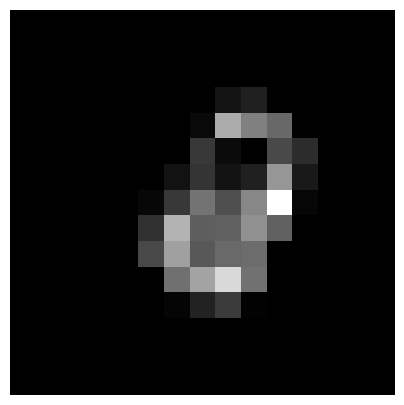

In [ ]:
# Show the kernel
plt.figure(figsize=(5, 5))
plt.imshow(h, cmap="gray")
plt.axis("off")
plt.savefig("images/kernel.png", bbox_inches="tight", pad_inches=0)

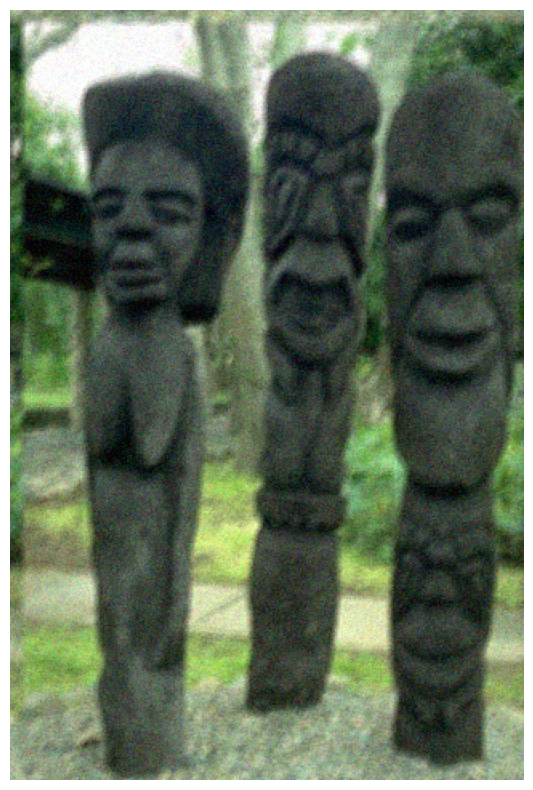

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(x_observed.clip(0, 1).transpose(1, 2, 0))
plt.axis("off")
plt.savefig("images/observed.png", bbox_inches="tight", pad_inches=0)

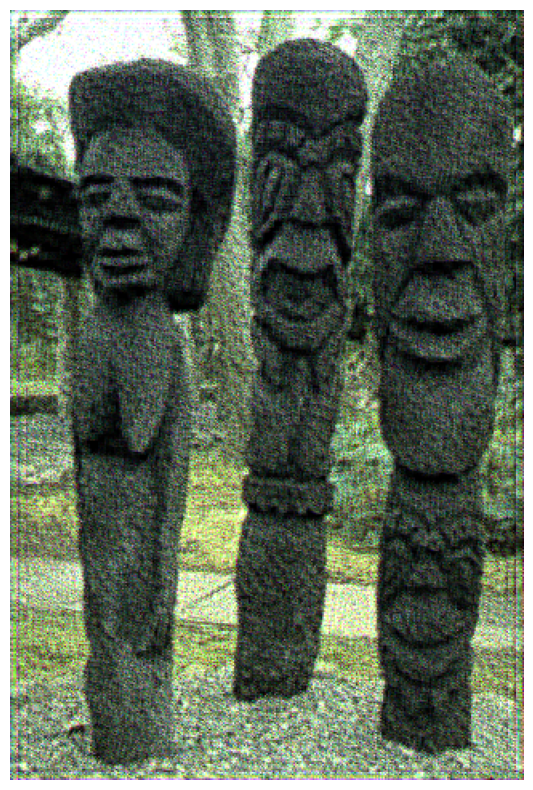

In [ ]:
name_path = "SD_10C_1L"

path_results = "convergence/"+name_path+"/results_optimal_lambda.pkl"

with open(path_results, "rb") as f:
    list_results = pickle.load(f)
    img_denoised = list_results["best_x_psnr"]
    best_psnr = list_results["best_psnr"]
    current_dual = list_results["best_current_dual"]

plt.figure(figsize=(10, 10))
plt.imshow(img_denoised.clip(0, 1).transpose(1, 2, 0))
plt.axis("off")
plt.savefig("images/"+name_path+".png", bbox_inches="tight", pad_inches=0)